# Evaluate network

In [1]:
from __future__ import annotations

from collections import defaultdict
from json import load
from pathlib import Path
from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML, display
from scipy.stats import ttest_ind, wasserstein_distance
from tabulate import tabulate

from adaptive_planner.evaluation import EvaluationResult
from adaptive_planner.io.kml import read_kml_file
from adaptive_planner.utils import parallel_execute, parallel_execute2
from adaptive_planner.visualisation import save_fig

if TYPE_CHECKING:
    from typing import Any

%matplotlib inline

plt.rcParams["text.usetex"] = True

Define helper functions:

In [2]:
def _display_table(table_html: str) -> None:
    display(
        HTML(
            f"""
        <div style="max-height: 300px; overflow-y: auto; border: 1px solid #ccc;">
            {table_html}
        </div>
        """
        )
    )


def _set_boxplot_color(boxplot: dict[str, Any], color: str) -> None:
    for patch in boxplot["boxes"]:
        patch.set_facecolor(color)


def read_times_json(times_file: Path) -> dict[str, tuple[float, float]]:
    inference_times = defaultdict(list)

    with times_file.open("r") as file_handler:
        json_data = load(file_handler)

        for img_times in json_data.values():
            inference_times["preprocess"].append(img_times["preprocess"])
            inference_times["inference"].append(img_times["inference"])
            inference_times["postprocess"].append(img_times["postprocess"])
            inference_times["inference_postprocess"].append(img_times["inference"] + img_times["postprocess"])
            inference_times["total"].append(img_times["preprocess"] + img_times["inference"] + img_times["postprocess"])

    return inference_times

Define the data files:

In [25]:
dropout_probability = 0.25
altitudes = [12, 24, 32]
datasets = ["clustered_1", "clustered_2", "clustered_3", "clustered_4", "uniform_1", "uniform_2", "uniform_3", "uniform_4"]
methods = ["yolo_uncertainty", "mcd_late_yolo_mean", "mcd_late_occ", "mcd_late_cls2", "mcd_late_iou", "mcd_late_occ_cls2_iou"]

gt_files = {f"{d}_{a}m": Path(f"detection_evaluation_results/{d}_{a}m_gt.kml") for a in altitudes for d in datasets}
detection_files = {
    f"{d}_{a}m_{m}": Path(f"detection_evaluation_results/{dropout_probability:.2f}_{m}/{d}_{a}m_{m}.kml") for a in altitudes for d in datasets for m in methods
}
time_files = {
    f"{d}_{a}m_{m}": Path(f"detection_evaluation_results/{dropout_probability:.2f}_{m}/{d}_{a}m_{m}_times.json") for a in altitudes for d in datasets for m in methods
}

assert all(f.is_file() for f in gt_files.values())
assert all(f.is_file() for f in detection_files.values())
assert all(f.is_file() for f in time_files.values())

Load the data:

In [26]:
gt = parallel_execute(gt_files, read_kml_file)
detections = parallel_execute(detection_files, read_kml_file)
processing_times = parallel_execute(time_files, read_times_json)

Define the labels:

In [27]:
LABEL_MAP = {
    "yolo_uncertainty": "yolo",
    "mcd_late_yolo_mean": "MCD yolo",
    "mcd_late_occ": "MCD occurrence",
    "mcd_late_cls2": "MCD class",
    "mcd_late_iou": "MCD localization",
    "mcd_late_occ_cls2_iou": "MCD combined",
}

## Detection accuracy
Run evaluations:

In [7]:
dt_gt_locations = {dt_k: (gt_v, dt_v) for dt_k, dt_v in detections.items() for gt_k, gt_v in gt.items() if gt_k in dt_k}
evaluations = parallel_execute2(
    dt_gt_locations, EvaluationResult.from_georeferenced_image_detections, use_uncertainty_measure_as_confidence=True
)

Show table:

In [8]:
rows = []
for alt in altitudes:
    f1 = []
    precision = []
    recall = []
    for ds in datasets:
        f1.append(evaluations[f"{ds}_{alt}m_yolo_uncertainty"].f1)
        precision.append(evaluations[f"{ds}_{alt}m_yolo_uncertainty"].precision)
        recall.append(evaluations[f"{ds}_{alt}m_yolo_uncertainty"].recall)

    rows.append(
        [
            alt,
            f"{np.mean(f1):.2f} ± {np.std(f1):.2f}",
            f"{np.mean(precision):.2f} ± {np.std(precision):.2f}",
            f"{np.mean(recall):.2f} ± {np.std(recall):.2f}",
        ]
    )

_display_table(tabulate(rows, headers=["Altitude", "F1-score", "Precision", "Recall"], tablefmt="html"))

Altitude,F1-score,Precision,Recall
12,0.83 ± 0.07,0.84 ± 0.07,0.83 ± 0.07
24,0.70 ± 0.07,0.78 ± 0.08,0.63 ± 0.07
32,0.44 ± 0.09,0.69 ± 0.07,0.33 ± 0.08


Class agnostic:

In [9]:
rows = []
for alt in altitudes:
    f1 = []
    precision = []
    recall = []
    for ds in datasets:
        f1.append(evaluations[f"{ds}_{alt}m_yolo_uncertainty"].make_class_agnostic().f1)
        precision.append(evaluations[f"{ds}_{alt}m_yolo_uncertainty"].make_class_agnostic().precision)
        recall.append(evaluations[f"{ds}_{alt}m_yolo_uncertainty"].make_class_agnostic().recall)

    rows.append(
        [
            alt,
            f"{np.mean(f1):.2f} ± {np.std(f1):.2f}",
            f"{np.mean(precision):.2f} ± {np.std(precision):.2f}",
            f"{np.mean(recall):.2f} ± {np.std(recall):.2f}",
        ]
    )

_display_table(tabulate(rows, headers=["Altitude", "F1-score", "Precision", "Recall"], tablefmt="html"))

Altitude,F1-score,Precision,Recall
12,0.95 ± 0.02,0.96 ± 0.01,0.95 ± 0.03
24,0.88 ± 0.03,0.98 ± 0.01,0.80 ± 0.05
32,0.63 ± 0.10,0.97 ± 0.02,0.48 ± 0.11


## Detection confidences
Evaluate the data with low confidence threshold:

In [28]:
dt_gt_locations = {dt_k: (gt_v, dt_v) for dt_k, dt_v in detections.items() for gt_k, gt_v in gt.items() if gt_k in dt_k}
evaluations = parallel_execute2(
    dt_gt_locations,
    EvaluationResult.from_georeferenced_image_detections,
    use_uncertainty_measure_as_confidence=True,
    conf_threshold=0.001,
    dist_threshold=0.35,
)

Sort the confidences in TPs and FPs:

In [29]:
tp_confidences = defaultdict(list)
fp_confidences = defaultdict(list)

for method in methods:
    for altitude in altitudes:
        for dataset in datasets:
            key = f"{dataset}_{altitude}m_{method}"

            indices_per_class = evaluations[key].get_tp_fp_fn_indices()
            for indices in indices_per_class.values():
                tp_confidences[f"{altitude}m_{method}"].extend(evaluations[key].conf[idx] for idx in indices[0])
                fp_confidences[f"{altitude}m_{method}"].extend(evaluations[key].conf[idx] for idx in indices[1])

Show t-value with alternative hypothesis that TP is larger than FP:

In [30]:
rows = []

for method in methods:
    row = [LABEL_MAP[method]]
    for alt in altitudes:
        t_value, p_value = ttest_ind(
            tp_confidences[f"{alt}m_{method}"], fp_confidences[f"{alt}m_{method}"], alternative="greater", equal_var=False
        )
        s_sign = "***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else ""))
        row.append(f"{t_value:.1f}{s_sign}")
    rows.append(row)

_display_table(tabulate(rows, headers=["Uncertainty measure"] + [f"{alt}m" for alt in altitudes], tablefmt="html"))

Uncertainty measure,12m,24m,32m
yolo,101.1***,48.3***,18.0***
MCD yolo,77.8***,40.7***,15.6***
MCD occurrence,41.6***,25.6***,11.1***
MCD class,78.7***,42.5***,18.3***
MCD localization,3.4***,-3.2,-5.1
MCD combined,61.4***,23.1***,5.7***


Create plot:

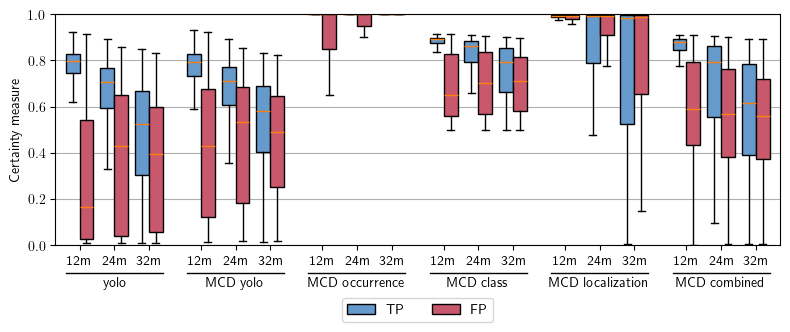

In [31]:
BAR_WIDTH = 0.4
OFFSET_BETWEEN_METHODS = 0.5


def gather_data(input_data: dict[str, list[float]]) -> list[list[float]]:
    data = []
    for method in methods:
        for altitude in altitudes:
            data.append(input_data[f"{altitude}m_{method}"])
    return data


tp_data = gather_data(tp_confidences)
fp_data = gather_data(fp_confidences)

positions = np.array([(i * (len(altitudes) + OFFSET_BETWEEN_METHODS)) + j for i in range(len(methods)) for j in range(len(altitudes))])

fig, ax = plt.subplots(figsize=(8, 3.2))
tp_boxes = ax.boxplot(tp_data, positions=positions - (BAR_WIDTH / 2), widths=BAR_WIDTH, showfliers=False, label="TP", patch_artist=True)
fp_boxes = ax.boxplot(fp_data, positions=positions + (BAR_WIDTH / 2), widths=BAR_WIDTH, showfliers=False, label="FP", patch_artist=True)

_set_boxplot_color(tp_boxes, "#6699CC")
_set_boxplot_color(fp_boxes, "#c8586c")

ax.set_ylabel("Certainty measure")
ax.set_xticks(positions, [f"{alt}m" for _ in methods for alt in altitudes])
ax.set_ylim(0.0, 1.0)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_yticks(np.linspace(0.0, 1.0, 6))

for i, method in enumerate(methods):
    start_i = i * (len(positions) // len(methods))
    end_i = (i + 1) * (len(positions) // len(methods)) - 1

    ax.text((positions[end_i] + positions[start_i]) / 2, ax.get_ylim()[0] - 0.18, LABEL_MAP[method], ha="center")
    ax.plot([positions[start_i] - BAR_WIDTH, positions[end_i] + BAR_WIDTH], [-0.12, -0.12], color="black", linewidth=1)[0].set_clip_on(
        False
    )

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), fancybox=True, ncol=2)

fig.tight_layout(rect=(0, -0.05, 1, 1.03))
save_fig("figures/uncertainty_measure/uncertainty_measures_boxplot.pdf", fig, format="pdf", dpi=600)
fig.show()

Distance between TP and FP:

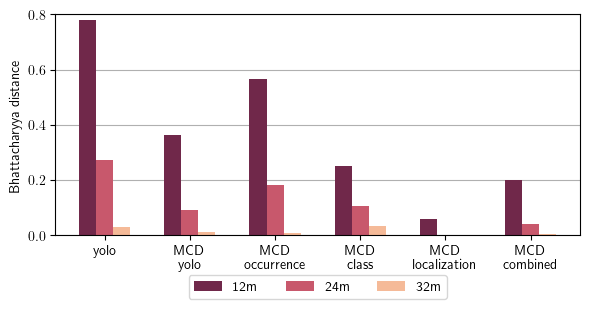

In [23]:
def bhattacharyya_distance(data1: list[float], data2: list[float]) -> float:
    mean1, var1 = np.mean(data1), np.var(data1)
    mean2, var2 = np.mean(data2), np.var(data2)

    term1 = 0.25 * np.log(0.25 * ((var1 / var2) + (var2 / var1) + 2))
    term2 = 0.25 * ((mean1 - mean2) ** 2) / (var1 + var2)

    return term1 + term2


colors = ["#70284a", "#c8586c", "#f5ba98"]

fig, ax = plt.subplots(figsize=(6, 3))

bar_width = 0.2
for i, altitude in enumerate(altitudes):
    method_data = []
    for method in methods:
        key = f"{altitude}m_{method}"
        method_data.append(bhattacharyya_distance(tp_confidences[key], fp_confidences[key]))

    ax.bar(np.arange(len(methods)) + i * bar_width, method_data, bar_width, label=f"{altitude}m", color=colors[i])

ax.set_ylabel("Bhattacharyya distance")
ax.set_xticks(np.arange(len(methods)) + (len(altitudes) - 1) / 2 * bar_width, [LABEL_MAP[m].replace(" ", "\n") for m in methods])
ax.grid(axis="y")
ax.set_ylim(0.0, 0.8)
ax.set_axisbelow(True)
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5))

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=3)

fig.tight_layout(rect=(0, -0.04, 1, 1.03))
save_fig("figures/uncertainty_measure/uncertainty_measures_bhattacharyya_distance.pdf", fig, format="pdf", dpi=600)
fig.show()

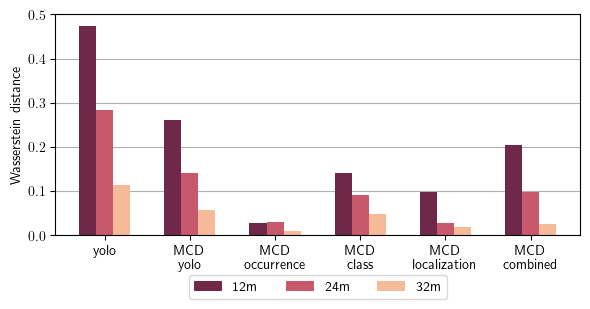

In [ ]:
colors = ["#70284a", "#c8586c", "#f5ba98"]

fig, ax = plt.subplots(figsize=(6, 3))

bar_width = 0.2
for i, altitude in enumerate(altitudes):
    method_data = []
    for method in methods:
        key = f"{altitude}m_{method}"
        method_data.append(wasserstein_distance(tp_confidences[key], fp_confidences[key]))

    ax.bar(np.arange(len(methods)) + i * bar_width, method_data, bar_width, label=f"{altitude}m", color=colors[i])

ax.set_ylabel("Wasserstein distance")
ax.set_xticks(np.arange(len(methods)) + (len(altitudes) - 1) / 2 * bar_width, [LABEL_MAP[m].replace(" ", "\n") for m in methods])
ax.grid(axis="y")
ax.set_ylim(0.0, 0.5)
ax.set_axisbelow(True)
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 6))

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=3)

fig.tight_layout(rect=(0, -0.04, 1, 1.03))
save_fig("figures/uncertainty_measure/uncertainty_measures_emd_distance.pdf", fig, format="pdf", dpi=600)
fig.show()

## Processing time

Group the data:

In [25]:
preprocess_times = defaultdict(list)
inference_times = defaultdict(list)
postprocess_times = defaultdict(list)
total_times = defaultdict(list)

for method in methods:
    for k, v in processing_times.items():
        if method in k:
            preprocess_times[method].extend(v["preprocess"])
            inference_times[method].extend(v["inference"])
            postprocess_times[method].extend(v["postprocess"])
            total_times[method].extend(v["total"])

Create table:

In [26]:
header = ["Uncertainty measure", "Preprocess time [ms]", "Inference time [ms]", "Postprocessing time [ms]", "Total time [ms]"]
rows = []


def _plusminus_std(values: list[float]) -> str:
    return f"{np.mean(values):.1f}±{np.std(values):.1f}"


mcd_preprocess_values = []
mcd_inference_values = []
mcd_postprocess_values = []
mcd_total_values = []
for method in methods:
    rows.append(
        [
            LABEL_MAP[method],
            _plusminus_std(preprocess_times[method]),
            _plusminus_std(inference_times[method]),
            _plusminus_std(postprocess_times[method]),
            _plusminus_std(total_times[method]),
        ]
    )

    if method != "yolo":
        mcd_preprocess_values.extend(preprocess_times[method])
        mcd_inference_values.extend(inference_times[method])
        mcd_postprocess_values.extend(postprocess_times[method])
        mcd_total_values.extend(total_times[method])

rows.append(
    [
        "MCD average",
        _plusminus_std(mcd_preprocess_values),
        _plusminus_std(mcd_inference_values),
        _plusminus_std(mcd_postprocess_values),
        _plusminus_std(mcd_total_values),
    ]
)

_display_table(tabulate(rows, headers=header, tablefmt="html"))

Uncertainty measure,Preprocess time [ms],Inference time [ms],Postprocessing time [ms],Total time [ms]
yolo,15.9±3.0,5.7±0.5,0.5±1.0,22.1±2.9
MCD yolo,13.9±0.8,36.3±0.4,44.5±60.5,94.7±60.6
MCD occurrence,13.7±0.8,35.6±0.7,82.5±139.1,131.8±138.9
MCD class,13.9±0.6,35.0±0.4,44.3±60.3,93.3±60.3
MCD localization,13.7±0.6,36.3±0.4,44.0±59.7,94.0±59.7
MCD combined,13.6±0.7,35.0±0.4,119.9±179.4,168.5±179.4
MCD average,14.0±1.5,31.4±10.5,59.7±113.8,105.2±116.1


Create plot:

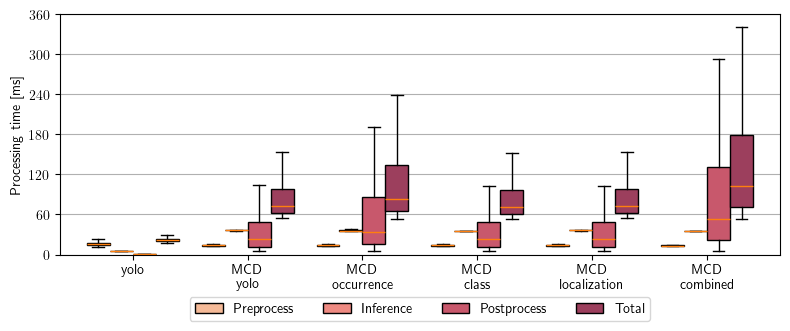

In [28]:
BAR_WIDTH = 0.3
OFFSET_BETWEEN_METHODS = 0.5


def gather_data(input_data: dict[str, list[float]]) -> list[list[float]]:
    return [input_data[method] for method in methods]


preprocess_data = gather_data(preprocess_times)
inference_data = gather_data(inference_times)
postprocess_data = gather_data(postprocess_times)
total_data = gather_data(total_times)

positions = np.arange(len(methods)) * (1 + OFFSET_BETWEEN_METHODS)

fig, ax = plt.subplots(figsize=(8, 3.2))
preprocess_boxes = ax.boxplot(
    preprocess_data, positions=positions - (BAR_WIDTH * 1.5), widths=BAR_WIDTH, showfliers=False, label="Preprocess", patch_artist=True
)
inference_boxes = ax.boxplot(
    inference_data, positions=positions - (BAR_WIDTH * 0.5), widths=BAR_WIDTH, showfliers=False, label="Inference", patch_artist=True
)
postprocess_boxes = ax.boxplot(
    postprocess_data, positions=positions + (BAR_WIDTH * 0.5), widths=BAR_WIDTH, showfliers=False, label="Postprocess", patch_artist=True
)
total_boxes = ax.boxplot(
    total_data, positions=positions + (BAR_WIDTH * 1.5), widths=BAR_WIDTH, showfliers=False, label="Total", patch_artist=True
)

_set_boxplot_color(preprocess_boxes, "#f5ba98")
_set_boxplot_color(inference_boxes, "#ee8a82")
_set_boxplot_color(postprocess_boxes, "#c8586c")
_set_boxplot_color(total_boxes, "#9c3f5d")

ax.set_ylabel("Processing time [ms]")
ax.set_xticks(positions, [LABEL_MAP[method].replace(" ", "\n") for method in methods])
ax.grid(axis="y")
ax.set_ylim(0.0, 360)
ax.set_axisbelow(True)
ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 7))

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4)

fig.tight_layout(rect=(0, -0.04, 1, 1.03))
save_fig("figures/uncertainty_measure/uncertainty_measures_processing_time_boxplot.pdf", fig, format="pdf", dpi=600)
fig.show()